# Class Imbalance Analysis

This notebook analyzes the class imbalance in wolf presence labels across years.


In [16]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [17]:
import tempfile
from pathlib import Path
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import rasterio
from google.cloud import storage

GCS_BUCKET = "wolfcast_training_samples"
LABEL_PREFIX = "labels"
START_YEAR = 1995
END_YEAR = 2022

try:
    plt.style.use('seaborn-v0_8-darkgrid')
except OSError:
    try:
        plt.style.use('seaborn-darkgrid')
    except OSError:
        plt.style.use('ggplot')
sns.set_palette("husl")


In [18]:
def download_from_gcs(gcs_path: str, local_path: Path) -> bool:
    if not gcs_path.startswith("gs://"):
        return False

    try:
        bucket_name = gcs_path.split("/")[2]
        blob_path = "/".join(gcs_path.split("/")[3:])
        client = storage.Client()
        bucket = client.bucket(bucket_name)
        blob = bucket.blob(blob_path)
        blob.download_to_filename(str(local_path))
        return True
    except Exception as e:
        print(f"[error] Failed to download {gcs_path}: {e}")
        return False


def analyze_year_labels(year: int):
    label_gcs = f"gs://{GCS_BUCKET}/{LABEL_PREFIX}/wolf_presence_{year}.tif"

    with tempfile.TemporaryDirectory() as tmpdir:
        tmp_path = Path(tmpdir)
        label_local = tmp_path / f"label_{year}.tif"

        if not download_from_gcs(label_gcs, label_local):
            return None

        with rasterio.open(label_local) as src:
            label_data = src.read(1)

            total_pixels = label_data.size
            positive_pixels = np.sum(label_data == 1)
            negative_pixels = np.sum(label_data == 0)
            nodata_pixels = total_pixels - positive_pixels - negative_pixels

            positive_pct = (positive_pixels / total_pixels) * 100 if total_pixels > 0 else 0
            negative_pct = (negative_pixels / total_pixels) * 100 if total_pixels > 0 else 0
            imbalance_ratio = negative_pixels / positive_pixels if positive_pixels > 0 else np.inf

            return {
                'year': year,
                'total_pixels': total_pixels,
                'positive_pixels': positive_pixels,
                'negative_pixels': negative_pixels,
                'nodata_pixels': nodata_pixels,
                'positive_pct': positive_pct,
                'negative_pct': negative_pct,
                'imbalance_ratio': imbalance_ratio,
                'width': src.width,
                'height': src.height
            }


In [19]:
# Analyze all years
print("Analyzing label files from GCS...")
results = []

for year in range(START_YEAR, END_YEAR + 1):
    print(f"Processing {year}...", end=" ")
    stats = analyze_year_labels(year)
    if stats:
        results.append(stats)
        print(f"✓ {stats['positive_pixels']:,} pos ({stats['positive_pct']:.2f}%)")
    else:
        print("✗ missing")

df = pd.DataFrame(results)
print(f"\nAnalyzed {len(df)} years")


Analyzing label files from GCS...
Processing 1995... ✓ 3,128,077 pos (5.31%)
Processing 1996... ✓ 8,087,755 pos (13.72%)
Processing 1997... ✓ 6,456,507 pos (10.96%)
Processing 1998... ✓ 7,799,009 pos (13.23%)
Processing 1999... ✓ 5,148,223 pos (8.74%)
Processing 2000... ✓ 5,462,827 pos (9.27%)
Processing 2001... ✓ 5,833,294 pos (9.90%)
Processing 2002... ✓ 6,058,325 pos (10.28%)
Processing 2003... ✓ 3,271,039 pos (5.55%)
Processing 2004... ✓ 3,898,787 pos (6.62%)
Processing 2005... ✓ 4,982,189 pos (8.45%)
Processing 2006... ✓ 3,888,444 pos (6.60%)
Processing 2007... ✓ 4,210,926 pos (7.15%)
Processing 2008... ✓ 5,119,683 pos (8.69%)
Processing 2009... ✓ 5,970,223 pos (10.13%)
Processing 2010... ✓ 4,297,423 pos (7.29%)
Processing 2011... ✓ 3,114,125 pos (5.28%)
Processing 2012... ✓ 4,900,403 pos (8.32%)
Processing 2013... ✓ 3,416,601 pos (5.80%)
Processing 2014... ✓ 4,333,630 pos (7.35%)
Processing 2015... ✓ 4,583,289 pos (7.78%)
Processing 2016... ✓ 4,262,206 pos (7.23%)
Processing 2017

In [20]:
# Display summary statistics
print("=" * 60)
print("CLASS IMBALANCE SUMMARY")
print("=" * 60)
print(f"\nTotal years analyzed: {len(df)}")
print(f"Average positive pixels per year: {df['positive_pixels'].mean():,.0f}")
print(f"Average positive percentage: {df['positive_pct'].mean():.2f}%")
print(f"Average imbalance ratio (neg:pos): {df['imbalance_ratio'].mean():.2f}:1")
print(f"\nMin positive %: {df['positive_pct'].min():.2f}% ({df.loc[df['positive_pct'].idxmin(), 'year']})")
print(f"Max positive %: {df['positive_pct'].max():.2f}% ({df.loc[df['positive_pct'].idxmax(), 'year']})")
print(f"\nTotal positive pixels (all years): {df['positive_pixels'].sum():,}")
print(f"Total negative pixels (all years): {df['negative_pixels'].sum():,}")

df


CLASS IMBALANCE SUMMARY

Total years analyzed: 27
Average positive pixels per year: 4,850,733
Average positive percentage: 8.23%
Average imbalance ratio (neg:pos): 11.93:1

Min positive %: 5.28% (2011)
Max positive %: 13.72% (1996)

Total positive pixels (all years): 130,969,801
Total negative pixels (all years): 1,460,223,089


,year,total_pixels,positive_pixels,negative_pixels,nodata_pixels,positive_pct,negative_pct,imbalance_ratio,width,height
0,1995,58933070,3128077,55804993,0,5.307847,94.692153,17.840032,7010,8407
1,1996,58933070,8087755,50845315,0,13.723627,86.276373,6.286703,7010,8407
2,1997,58933070,6456507,52476563,0,10.955660,89.044340,8.127702,7010,8407
3,1998,58933070,7799009,51134061,0,13.233672,86.766328,6.556482,7010,8407
4,1999,58933070,5148223,53784847,0,8.735712,91.264288,10.447264,7010,8407
5,2000,58933070,5462827,53470243,0,9.269544,90.730456,9.788017,7010,8407
6,2001,58933070,5833294,53099776,0,9.898168,90.101832,9.102880,7010,8407
7,2002,58933070,6058325,52874745,0,10.280009,89.719991,8.727618,7010,8407
8,2003,58933070,3271039,55662031,0,5.550430,94.449570,17.016621,7010,8407
9,2004,58933070,3898787,55034283,0,6.615618,93.384382,14.115745,7010,8407


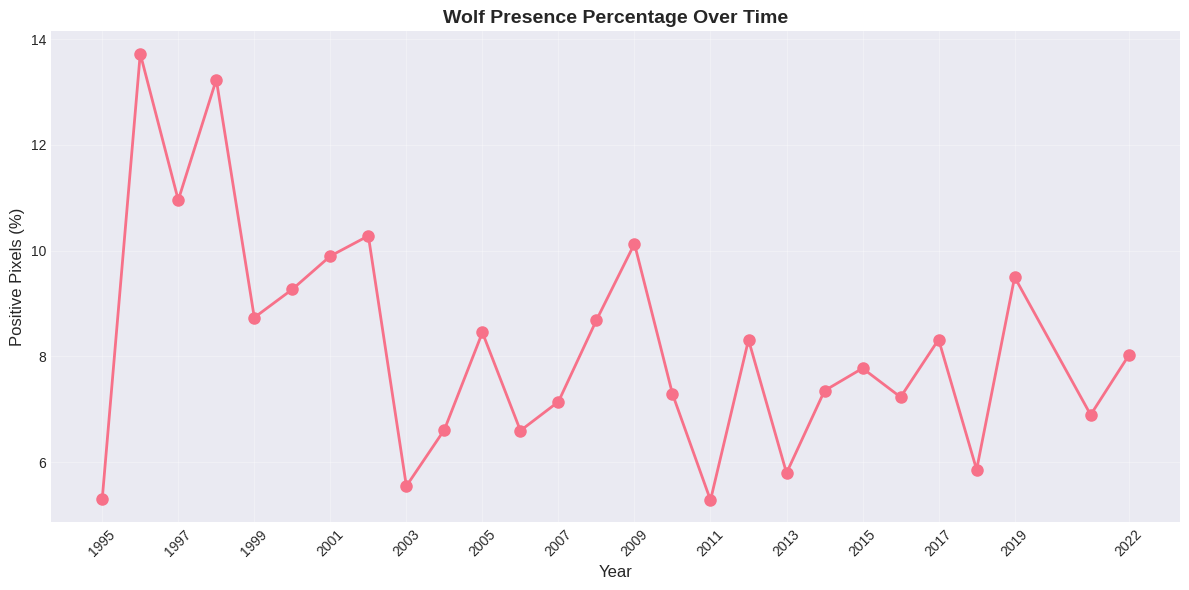

In [21]:
# Plot 1: Positive percentage over time
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df['year'], df['positive_pct'], marker='o', linewidth=2, markersize=8)
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Positive Pixels (%)', fontsize=12)
ax.set_title('Wolf Presence Percentage Over Time', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.set_xticks(df['year'][::2])  # Show every other year
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


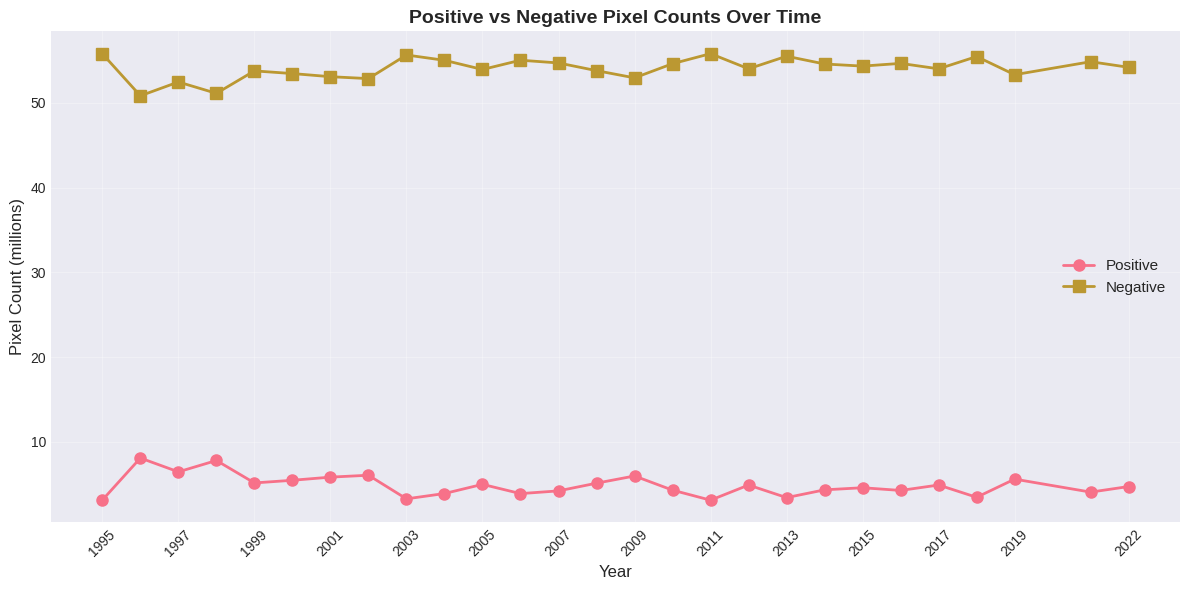

In [22]:
# Plot 2: Absolute counts over time
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df['year'], df['positive_pixels'] / 1e6, marker='o', label='Positive', linewidth=2, markersize=8)
ax.plot(df['year'], df['negative_pixels'] / 1e6, marker='s', label='Negative', linewidth=2, markersize=8)
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Pixel Count (millions)', fontsize=12)
ax.set_title('Positive vs Negative Pixel Counts Over Time', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_xticks(df['year'][::2])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


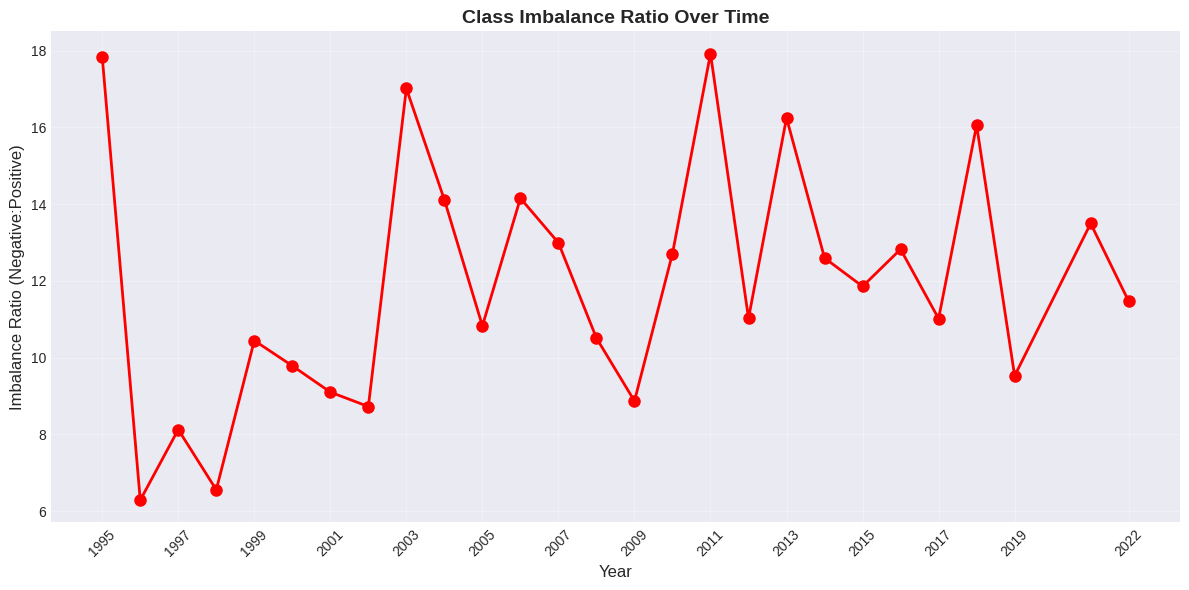

In [23]:
# Plot 3: Imbalance ratio over time
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df['year'], df['imbalance_ratio'], marker='o', linewidth=2, markersize=8, color='red')
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Imbalance Ratio (Negative:Positive)', fontsize=12)
ax.set_title('Class Imbalance Ratio Over Time', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.set_xticks(df['year'][::2])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


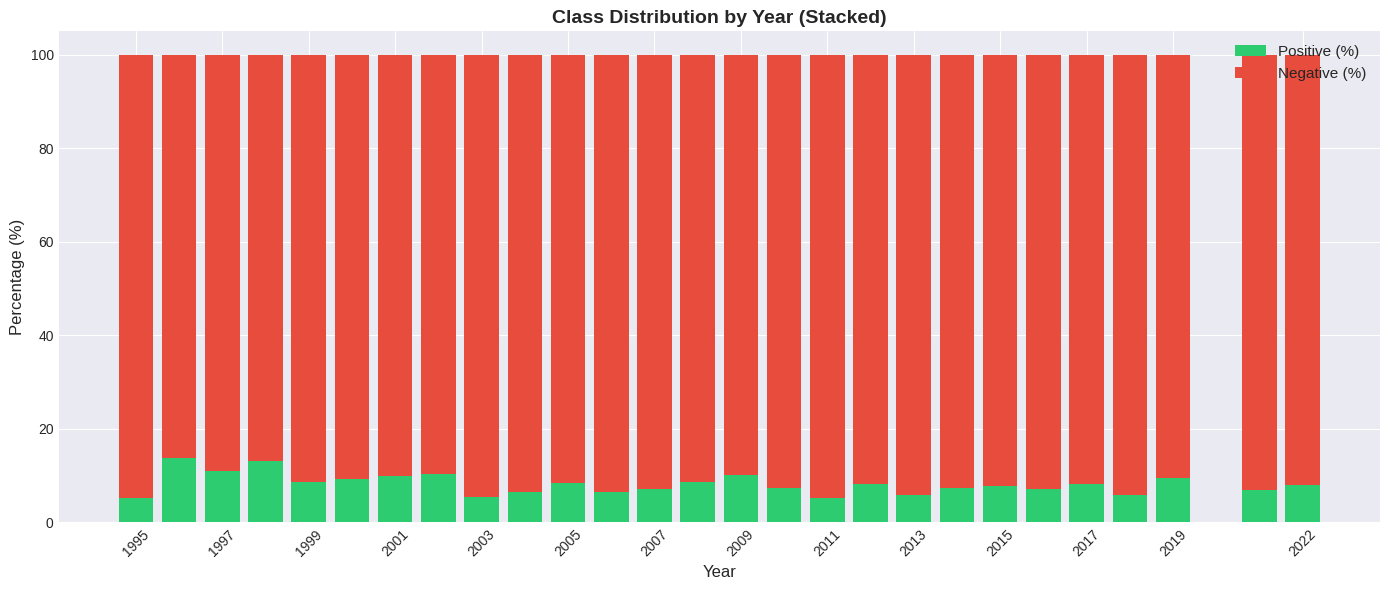

In [24]:
# Plot 4: Stacked bar chart showing positive vs negative percentages
fig, ax = plt.subplots(figsize=(14, 6))
x = df['year']
width = 0.8
ax.bar(x, df['positive_pct'], width, label='Positive (%)', color='#2ecc71')
ax.bar(x, df['negative_pct'], width, bottom=df['positive_pct'], label='Negative (%)', color='#e74c3c')
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Percentage (%)', fontsize=12)
ax.set_title('Class Distribution by Year (Stacked)', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.set_xticks(df['year'][::2])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


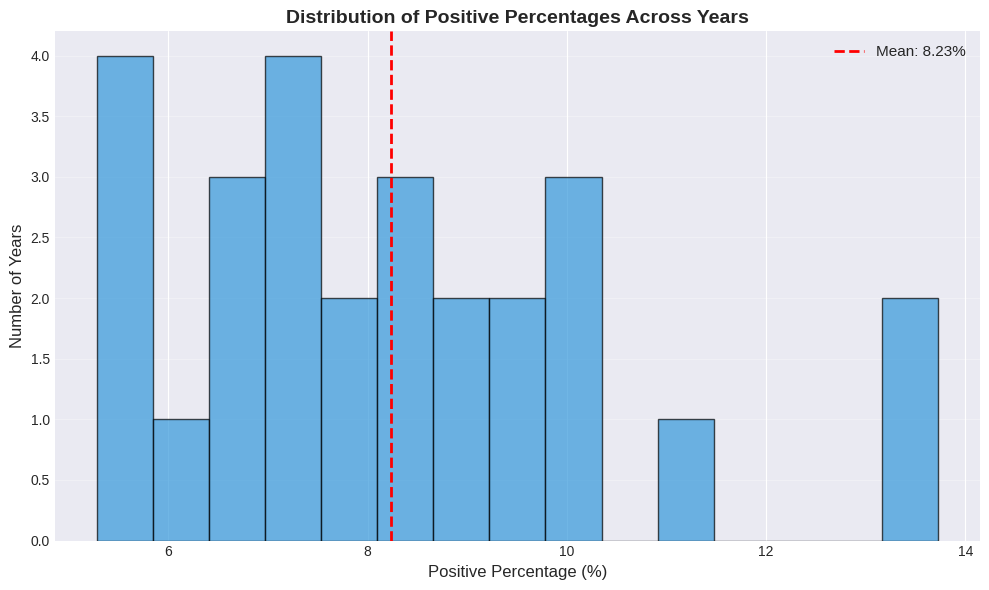

In [25]:
# Plot 5: Histogram of positive percentages
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(df['positive_pct'], bins=15, edgecolor='black', alpha=0.7, color='#3498db')
ax.set_xlabel('Positive Percentage (%)', fontsize=12)
ax.set_ylabel('Number of Years', fontsize=12)
ax.set_title('Distribution of Positive Percentages Across Years', fontsize=14, fontweight='bold')
ax.axvline(df['positive_pct'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df["positive_pct"].mean():.2f}%')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()


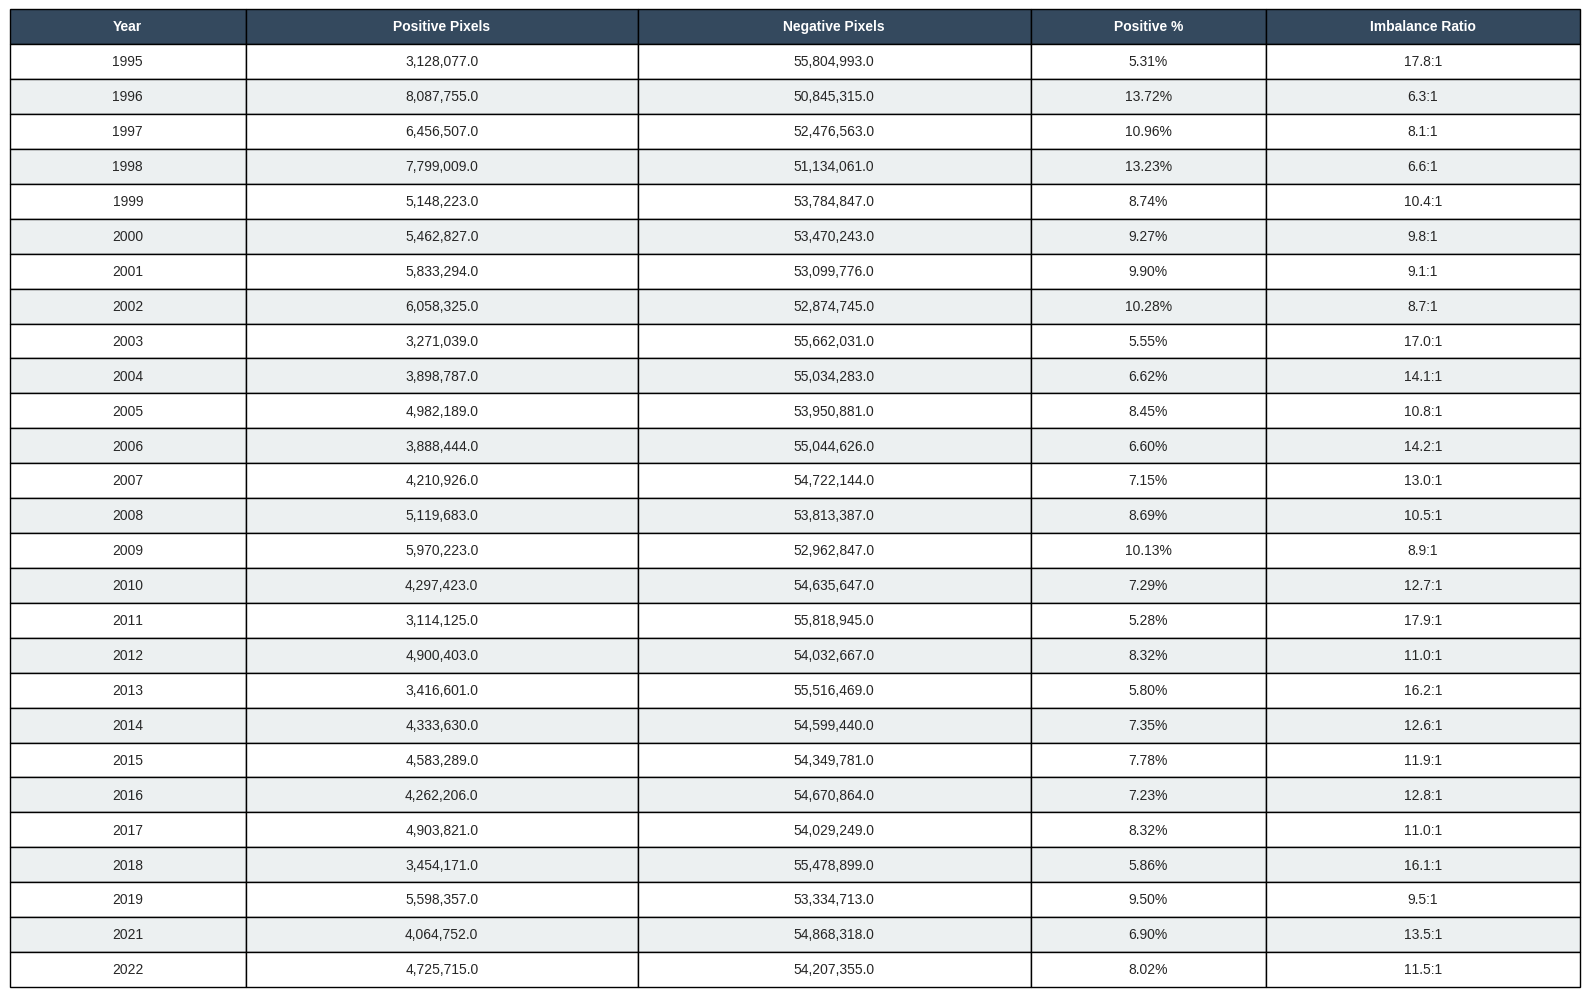

In [26]:
# Plot 6: Yearly statistics table visualization
fig, ax = plt.subplots(figsize=(16, 10))
ax.axis('tight')
ax.axis('off')

table_data = []
for _, row in df.iterrows():
    table_data.append([
        int(row['year']),
        f"{row['positive_pixels']:,}",
        f"{row['negative_pixels']:,}",
        f"{row['positive_pct']:.2f}%",
        f"{row['imbalance_ratio']:.1f}:1"
    ])

table = ax.table(cellText=table_data,
                colLabels=['Year', 'Positive Pixels', 'Negative Pixels', 'Positive %', 'Imbalance Ratio'],
                cellLoc='center',
                loc='center',
                colWidths=[0.15, 0.25, 0.25, 0.15, 0.2])

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)

for i in range(5):
    table[(0, i)].set_facecolor('#34495e')
    table[(0, i)].set_text_props(weight='bold', color='white')

for i in range(1, len(table_data) + 1):
    if i % 2 == 0:
        for j in range(5):
            table[(i, j)].set_facecolor('#ecf0f1')

plt.tight_layout()
plt.show()


In [27]:
# Export results to CSV
output_path = "class_imbalance_analysis.csv"
df.to_csv(output_path, index=False)
print(f"Results exported to: {output_path}")


Results exported to: class_imbalance_analysis.csv
